In [ ]:
!pip install wfdb
!pip install neurokit2

import pandas as pd
import numpy as np
import wfdb
import ast
from google.colab import drive

# Mount Google Drive
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = 'ptb-xl-100hz.zip'
extraction_dir = 'ptb-xl-100hz'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_dir)

print(f"Files extracted to {extraction_dir}")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 140.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
ERROR: Operation cancelled by user
  Using cached pandas-3.0.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 19.7 MB/s eta 0:00:00
Using cached pandas-3.0.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.0 

ModuleNotFoundError: No module named 'wfdb'

# Data Loading and Preprocessing

In [ ]:

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]

    data = np.array([signal for signal, meta in data])
    return data

# Update the path to your Google Drive
path = 'ptb-xl-100hz/ptb-xl-100hz/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0) # takes all scp statements in the file
agg_df = agg_df[agg_df.diagnostic == 1] # filters them to only include diagnostic statements

def aggregate_diagnostic(y_dic):
   # for each entry take each diagnostic statement and add to entry in temporary lsit which is returned
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
valid_fold = 9


# Train
X_train = X[np.where(Y.strat_fold <valid_fold)]
y_train = Y[(Y.strat_fold <valid_fold)].diagnostic_superclass

# Validation
X_valid = X[np.where(Y.strat_fold == valid_fold)]
y_valid = Y[(Y.strat_fold == valid_fold)].diagnostic_superclass

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass





In [ ]:
import numpy
import copy
import torch
from torch.utils.data import DataLoader, TensorDataset
import neurokit2 as nk



def create_dataset(data, labels):

  """
  Data formatted as [R, S, L]
  R: record
  S: number of samples or sample index / features
  L: lead

  Each record has 1000 samples (as its 100hz recording over 10 seconds so 100*10)
  Each sample in the record has data for each lead.

  """

  inv_labels_map = {
      0: 'NORM',
      1: 'HYP',
      2: 'MI',
      3: 'CD',
      4: 'STTC',
  }

  labels_map = {v:k for k,v in inv_labels_map.items()}

  final_labels = []
  final_data = []
  removed = []



  for i, item in enumerate(labels.values):
    if item:

      twelve_lead = []

      for lead in range(12):
        twelve_lead.append(data[i,:,lead])


      final_labels.append(labels_map[item[0]])
      #final_data.append(nk.ecg_clean(data[i,:,:],100))
      final_data.append(twelve_lead) # DEFUNCT: For each record store it as all the samples over 1 lead. Should be reformatted as [R, S]

    else:
      removed.append(i)

  return removed, TensorDataset(torch.Tensor(np.array(final_data)), torch.LongTensor(final_labels))


leads = ['I', 'II', 'III', 'aVR' , 'aVL','aVF','V1','V2','V3','V4','V5','V6']




# for multilabel maybe do embeddings
#weight classes with the crossentropyloss torch func

In [ ]:


lead_num = 1 # defunct for multi-lead

train_removed, train_dataset = create_dataset(X_train, y_train)


valid_removed, valid_dataset = create_dataset(X_valid, y_valid)

test_removed, test_dataset = create_dataset(X_test, y_test)

# Datasets in format [R,L,S]
"""
torch.manual_seed(1)

train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

# This splits data into [B, Rb, L, S] for X data and [B, Rb, L, T] for y data where B = number of batches, Rb = records in batch 50 until final batch  and T = label/truth
# for the case of train_dl X = [342, Rb, 1000] Rb is 50 for all but the last entry where it is 34"""

counts_train = torch.unique(valid_dataset.tensors[1], return_counts=True)[1]
total_train = sum(counts_train)



weighting = torch.Tensor([i/total_train for i in counts_train])



# Model Code

In [ ]:
import torch.nn as nn

class PatchEmbed1D(nn.Module):

  def __init__(self, patch_size, embed_dim, num_leads=12):
    super().__init__()
    self.num_leads = num_leads
    self.patch_size = patch_size
    self.embed_dim = embed_dim

    self.proj = nn.Conv1d(num_leads, num_leads*embed_dim, patch_size, groups=num_leads, stride=patch_size) # outputs [B, L*D, N] Where D = embed dimension and N is number of patches

  def forward(self,x):
    x = self.proj(x) # B L*D, N

    B, _, N = x.size()
    x = x.view(B, self.num_leads, self.embed_dim, N).transpose(2,3) # B, L, N, D
    return x

class PositionalEncoding(nn.Module):
  def __init__(self, embed_dim, seq_len):
    super().__init__()
    self.pos_encoding = nn.Parameter(torch.randn(1, 1, seq_len, embed_dim))

  def forward(self, x):
    return x + self.pos_encoding

class LeadEncoding(nn.Module):
  def __init__(self, num_leads, embed_dim, seq_len):
    super().__init__()
    self.lead_encoding = nn.Parameter(torch.randn(1, num_leads, 1, embed_dim))

  def forward(self, x):
    return x + self.lead_encoding

class TransformerBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_hidden, dropout):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.mlp_hidden = mlp_hidden
    self.dropout = dropout

    self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim, mlp_hidden),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden, embed_dim),
        nn.GELU(),
        nn.Dropout(dropout)
    )

    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)

  def forward(self, x):
    x = self.norm1(x)
    t, _ = self.attention(x,x,x)
    x = x + t
    x = x+ self.mlp(self.norm2(x))

    return x

class TransformerECG(nn.Module):
  def __init__(self, num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout):
    super().__init__()

    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.num_leads = num_leads



    self.patch = PatchEmbed1D(self.patch_size, self.embed_dim, self.num_leads)

    self.blocks = nn.ModuleList([
        TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)
    ])

    L_IN = 1000 # number of records per lead. Constant
    self.N = (L_IN - patch_size) // patch_size + 1 # derived from equation from pytorch docs given padding = 0, dialation =1 and stride = 1
    self.pos_encoding = PositionalEncoding(self.embed_dim, self.N)
    self.lead_encoding = LeadEncoding(self.num_leads, self.embed_dim, self.N)

    self.lin_norm = nn.LayerNorm(2*embed_dim)


    self.mlp_head = nn.Linear(2*embed_dim, 5)




  def forward(self, x):

    #encodings and embeddings
    x = self.patch(x)
    x = self.pos_encoding(x)
    x = self.lead_encoding(x)

    B , L , N , D = x.size()

    x = x.reshape(B*L, N, D)# B*L N D

    for block in self.blocks:
      x = block(x)

    x = x.reshape(B, L, N, D)# B L N D

    #print(x.shape) Classify per lead

    B, L, N, D = x.shape
    tokens = x.view(B, L * N, D)
    mean_pool = tokens.mean(dim=1) # (B, D)
    max_pool, _ = tokens.max(dim=1) # (B, D)
    pooled = torch.cat([mean_pool, max_pool], dim=1) # (B, 2*D)
    logits = self.mlp_head(self.lin_norm(pooled)) # (B, num_classes) return logits

    return logits









# Model Training Function

In [ ]:


def train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=None, lam=0.01, num_epochs=50):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs

    best_loss = 1000

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:

            x_batch = x_batch.cuda(non_blocking=True)
            y_batch = y_batch.cuda(non_blocking=True)

            pred = model(x_batch)

            #print(pred)
            #print(pred.shape)

            loss = loss_fn(pred, y_batch)



            # Apply L1 regularization
            if regularisation_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lam * l1_norm

            # Apply L2 regularization
            elif regularisation_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lam * l2_norm


            loss.backward() # compute gradient based on results of all predictions made by the model given the inputs, in this case the batches

            optimiser.step()

            optimiser.zero_grad() # resets gradient

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.cuda(non_blocking=True)
                y_batch = y_batch.cuda(non_blocking=True)

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                 # Apply L1 regularization
                if regularisation_type == 'L1':
                  l1_norm = sum(p.abs().sum() for p in model.parameters())
                  loss += lam * l1_norm

                # Apply L2 regularization
                elif regularisation_type == 'L2':
                  l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                  loss += lam * l2_norm

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)

        if loss_hist_valid[epoch] < best_loss:
          best_loss = loss_hist_valid[epoch]
          best_epoch = epoch
          torch.save(model.state_dict(), 'model.pth')


        print(f'Epoch {epoch} Train_loss = {loss_hist_train[epoch]}, Valid_loss = {loss_hist_valid[epoch]}')



        del y_batch, x_batch, loss, pred
        torch.cuda.empty_cache()

    return loss_hist_train, loss_hist_valid, best_loss, best_epoch





# Model wrapper function

In [ ]:

def estimator(batch_size, num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, learning_rate,regularisation, num_epochs=20):

  torch.manual_seed(1)

  train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

  model = nn.DataParallel(TransformerECG(num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout))
  model = model.to('cuda')

  loss_fn = nn.CrossEntropyLoss(weight=weighting.to('cuda'))

  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  print(len(train_dl.dataset), len(valid_dl.dataset))

  loss_hist_train, loss_hist_valid, best_loss, best_epoch = train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=regularisation, num_epochs=num_epochs, lam=0.0005)

  return model, loss_hist_train, loss_hist_valid, best_loss, best_epoch


# Grid Search (defunct)

In [ ]:
import itertools
from sklearn import metrics

parameter_grid = {
    'batch_size': [32, 64, 128],
    'kernel_size': [5, 9, 13],
    'pool_size': [2, 3],
    'padding': [2, 4, 6],
    'drop_p': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001],
}

def grid_search(estimator, parameter_grid):

  best_val_loss = float('inf')
  best_params = {}

  best_losses = [] #0 is train 1 is valid

  best_f1 = 0

  keys = parameter_grid.keys()



  if torch.cuda.is_available():
      print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
  else:
      print("No GPU available. Training will run on CPU.")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  for values in itertools.product(*parameter_grid.values()):
      current_params = dict(zip(keys, values))

      batch_size = current_params['batch_size']
      kernel_size = current_params['kernel_size']
      pool_size = current_params['pool_size']
      padding = current_params['padding']
      drop_p = current_params['drop_p']
      learning_rate = current_params['learning_rate']

      print(f"Testing parameters: {current_params}")

      model, current_val_loss, loss_hist_train, loss_hist_valid = estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate)

      print(f"Validation Loss: {current_val_loss}")

      pred_val = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach().numpy()
      pred_val_values = np.argmax(pred_val,axis=1)

      f1_score_val = metrics.f1_score(valid_dataset.tensors[1],pred_val_values, average='macro')

      print(f"Validation f1: {f1_score_val}")

      plot_loss_history(loss_hist_train, loss_hist_valid)

      if current_val_loss < best_val_loss:
          best_val_loss = current_val_loss
          best_params = current_params
          best_f1 = f1_score_val
          best_losses = [loss_hist_train, loss_hist_valid]

  print(f"\nBest validation loss: {best_val_loss}")
  print(f"Best parameters: {best_params}")

  return best_params



# Model Training

In [ ]:
from sklearn import metrics


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()

num_leads = 12
embed_dim = 160
patch_size = 20
num_heads = 8
depth = 8
mlp_dim = 512
dropout = 0.2
learning_rate = 0.0003
regularisation = 'L2'
batch_size = 16

labels = ['NORM', 'HYP', 'MI', 'CD', 'STTC']

model, loss_hist_train, loss_hist_valid, best_loss, best_epoch = estimator(batch_size, num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, learning_rate, regularisation, num_epochs=60)

print(f"Validation Loss: {loss_hist_valid[-1]}")


GPU: NVIDIA A100-SXM4-40GB is available.
cuda
17084 2146
Epoch 0 Train_loss = 5.800178828939457, Valid_loss = 4.378489787625244
Epoch 1 Train_loss = 3.6289679458174264, Valid_loss = 3.0246146109652985
Epoch 2 Train_loss = 2.599830990735275, Valid_loss = 2.264034695638637
Epoch 3 Train_loss = 1.9827034465324904, Valid_loss = 1.7806783986780428
Epoch 4 Train_loss = 1.6170088972148837, Valid_loss = 1.5032995484859613
Epoch 5 Train_loss = 1.3869520956949115, Valid_loss = 1.3107578909408235
Epoch 6 Train_loss = 1.2278953379809898, Valid_loss = 1.1959027159691746
Epoch 7 Train_loss = 1.132298124587332, Valid_loss = 1.1338021524132464
Epoch 8 Train_loss = 1.0695217135806074, Valid_loss = 1.1015550633067854
Epoch 9 Train_loss = 1.0257381057047057, Valid_loss = 1.0208320984302675
Epoch 10 Train_loss = 0.9931578545038942, Valid_loss = 1.0029313146568077
Epoch 11 Train_loss = 0.9641491186699748, Valid_loss = 0.9946201079822764
Epoch 12 Train_loss = 0.9387883257597956, Valid_loss = 0.9481246888026

# Model Evaluation Metrics

In [ ]:
import matplotlib.pyplot as plt
print(f"Best Validation Loss: {best_loss} at epoch {best_epoch}")


def plot_loss_history(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



Best Validation Loss: 0.7211916546674944 at epoch 50


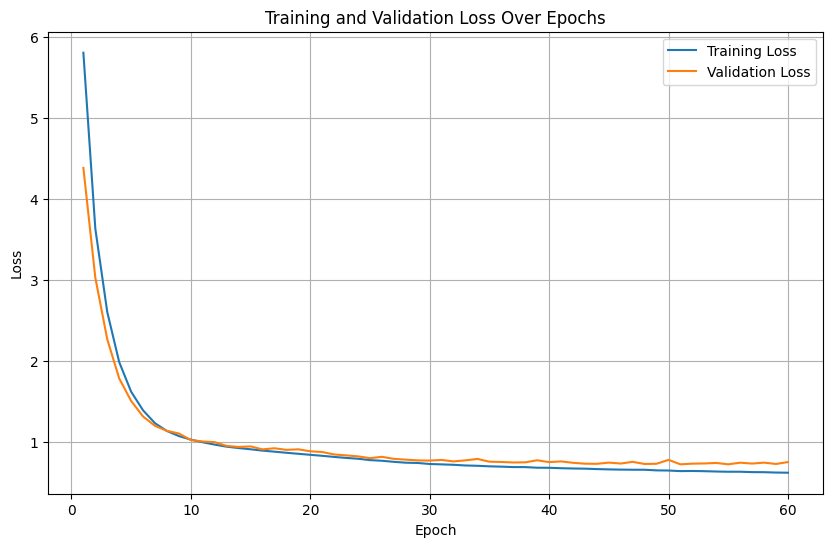

Evaluating on Validation Set...
Validation F1 Score: 0.46920049906863276


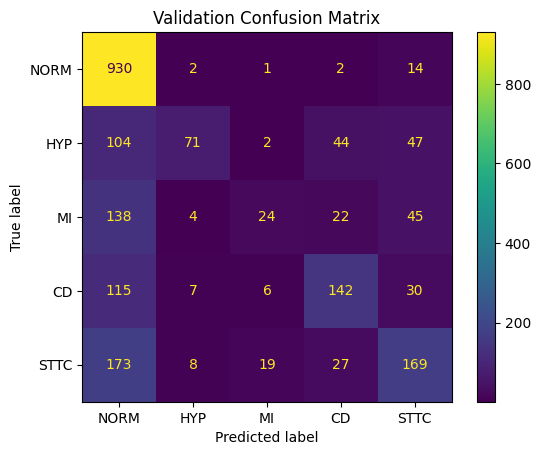

Evaluating on Training Set...
Training F1 Score: 0.5335014265537725


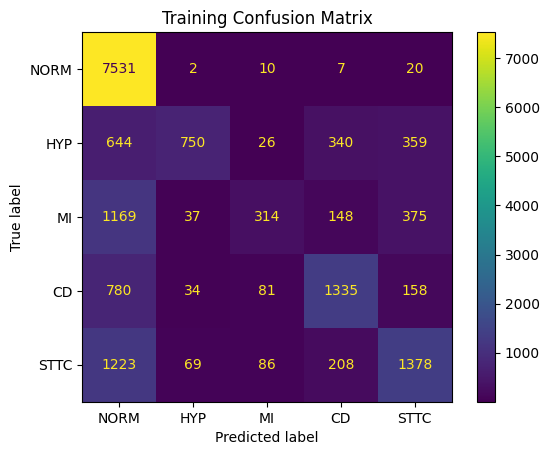


Final Comparison:
Validation F1: 0.4692
Training F1: 0.5335


In [ ]:
loaded_model = nn.DataParallel(TransformerECG(num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout)).to(device)
loaded_model.load_state_dict(torch.load('model.pth'))


def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)

            outputs = model(x_batch)

            all_preds.append(outputs.cpu())
            all_labels.append(y_batch)

    return torch.cat(all_preds), torch.cat(all_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

plot_loss_history(loss_hist_train, loss_hist_valid)

print("Evaluating on Validation Set")
val_logits, val_true = get_predictions(model, valid_loader)
val_preds = np.argmax(val_logits.numpy(), axis=1)
val_true = val_true.numpy()

f1_val = metrics.f1_score(val_true, val_preds, average='macro')
print(f"Validation F1 Score: {f1_val}")

cm_val = metrics.confusion_matrix(val_true, val_preds, labels=range(len(labels)))
disp_val = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

print("Evaluating on Training Set")
train_logits, train_true = get_predictions(model, train_loader)
train_preds = np.argmax(train_logits.numpy(), axis=1)
train_true = train_true.numpy()

f1_train = metrics.f1_score(train_true, train_preds, average='macro')
print(f"Training F1 Score: {f1_train}")

cm_train = metrics.confusion_matrix(train_true, train_preds, labels=range(len(labels)))
disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_train.plot()
plt.title("Training Confusion Matrix")
plt.show()

print(f"\nFinal Comparison:\nValidation F1: {f1_val:.4f}\nTraining F1: {f1_train:.4f}")

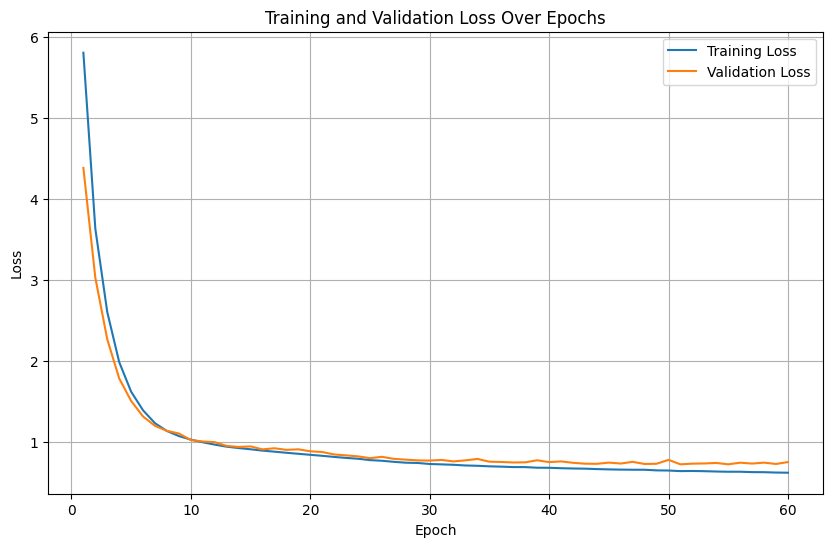

Evaluating on Validation Set...
Validation F1 Score: 0.45338417238018086


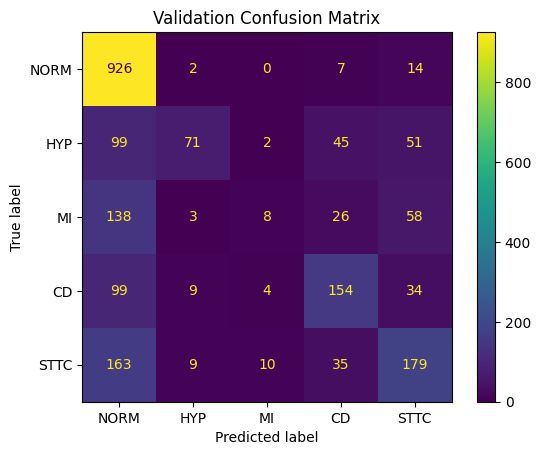

Evaluating on Training Set...
Training F1 Score: 0.5162159315183243


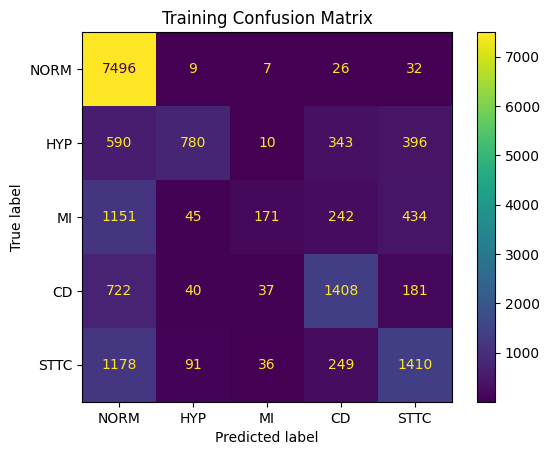


Final Comparison:
Validation F1: 0.4534
Training F1: 0.5162


In [ ]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            all_preds.append(outputs.cpu())
            all_labels.append(y_batch)

    return torch.cat(all_preds), torch.cat(all_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

plot_loss_history(loss_hist_train, loss_hist_valid)

print("Evaluating on Validation Set")
val_logits, val_true = get_predictions(loaded_model, valid_loader)
val_preds = np.argmax(val_logits.numpy(), axis=1)
val_true = val_true.numpy()

f1_val = metrics.f1_score(val_true, val_preds, average='macro')
print(f"Validation F1 Score: {f1_val}")

cm_val = metrics.confusion_matrix(val_true, val_preds, labels=range(len(labels)))
disp_val = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

print("Evaluating on Training Set")
train_logits, train_true = get_predictions(loaded_model, train_loader)
train_preds = np.argmax(train_logits.numpy(), axis=1)
train_true = train_true.numpy()

f1_train = metrics.f1_score(train_true, train_preds, average='macro')
print(f"Training F1 Score: {f1_train}")

cm_train = metrics.confusion_matrix(train_true, train_preds, labels=range(len(labels)))
disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_train.plot()
plt.title("Training Confusion Matrix")
plt.show()

print(f"\nFinal Comparison:\nValidation F1: {f1_val:.4f}\nTraining F1: {f1_train:.4f}")